In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU,Dropout
import librosa
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import curve_fit
import seaborn as sns

2024-06-12 14:18:53.497327: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 14:18:53.520717: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 14:18:53.520740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 14:18:53.520754: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 14:18:53.525057: I tensorflow/core/platform/cpu_feature_g

In [2]:
def df_to_vector_array(
        df,
        sampling_rate = 48000,
        hop_length = 2048,
        n_fft = 65536
    ):
    ample_array = np.array(df.loc[:,'ample'])
    n_fft = n_fft

    # フレームごとのシフトサイズ（一般的には `n_fft // 4` など）
    hop_length = hop_length

    # メルスペクトログラムの生成
    mel_spectrogram = librosa.feature.melspectrogram(y=ample_array, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length)
    freqs = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sampling_rate/2) 
    index = np.abs(np.array(freqs) - 1000).argmin()

    mel_spectrogram = mel_spectrogram[index:,:]
    # # MFCC の計算 (13係数で設定)
    # mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), n_mfcc=13)

    return mel_spectrogram

In [3]:
sampling_rate = 48000
df = pd.read_csv('../data/20240509/raw/mic_normal1.csv')
mfccs = df_to_vector_array(df, sampling_rate = sampling_rate)

In [4]:
mfccs.shape

(97, 1405)

In [5]:
for i in range(8):
    path_to_coodinate = f'../data/20240509/raw/coordinates_normal{i}.csv'
    path_to_sound = f'../data/20240509/raw/mic_normal{i}.csv'
    coordinate_df = pd.read_csv(path_to_coodinate)
    
    sound_df = pd.read_csv(path_to_sound)
    mel_spectrograms = df_to_vector_array(sound_df)
    time_stamp = [(16384/2+i*2048) /48000 for i in range(mel_spectrograms.shape[1])]
    print(mel_spectrograms.shape)
    mel_spectrogram_df = pd.DataFrame({
        'time': time_stamp
    })
    
    for j in range(97):
        mel_spectrogram_df[f'mel_spectrogram_{j}'] = mel_spectrograms[j]
    merged_data = pd.merge_asof(mel_spectrogram_df, coordinate_df, on='time', direction='nearest')
    merged_data.to_csv(f'../data/20240509/processed_mel_spectrogram_highpass/mel_spectrogram_coordinate{i}.csv')
data_frames_normal = []

for i in range(2):
    path_to_coodinate = f'../data/20240509/raw/coordinates_abnormal{i}.csv'
    path_to_sound = f'../data/20240509/raw/mic_abnormal{i}.csv'
    coordinate_df = pd.read_csv(path_to_coodinate)
    
    sound_df = pd.read_csv(path_to_sound)
    mel_spectrograms = df_to_vector_array(sound_df)
    time_stamp = [(16384/2+i*2048) /48000 for i in range(mel_spectrograms.shape[1])]
    mel_spectrogram_df = pd.DataFrame({
        'time': time_stamp
    })
    
    for j in range(97):
        mel_spectrogram_df[f'mel_spectrogram_{j}'] = mel_spectrograms[j]
    merged_data = pd.merge_asof(mel_spectrogram_df, coordinate_df, on='time', direction='nearest')
    merged_data.to_csv(f'../data/20240509/processed_mel_spectrogram_highpass/abnormal_mel_spectrogram_coordinate{i}.csv')

(97, 1404)
(97, 1405)
(97, 1406)
(97, 1405)
(97, 1052)
(97, 1051)
(97, 1051)
(97, 1051)


In [103]:
data_frames_abnormal = []
data_frames = []
for i in range(8):
    if(i == 3 or   i == 7):
        continue
    # if(i == 1 or i == 2 or i == 3 or i == 5 or i == 6 or i == 7):
    #     continue
    path_to_mel_spectrogram_coord = f'../data/20240509/processed_mel_spectrogram_highpass/mel_spectrogram_coordinate{i}.csv'
    df = pd.read_csv(path_to_mel_spectrogram_coord)
    data_frames.append(df)
    
combined_df = pd.concat(data_frames, ignore_index=True)

y_columns_to_use = [f'mel_spectrogram_{i}' for i in range(97)]

y_train = combined_df[y_columns_to_use].values

x_columns_to_use = ['x','y']
x_train = combined_df[x_columns_to_use].values


data_frames_abnormal = []

for i in range(2):
    path_to_mel_spectrogram_coord = f'../data/20240509/processed_mel_spectrogram_highpass/abnormal_mel_spectrogram_coordinate{i}.csv'
    df = pd.read_csv(path_to_mel_spectrogram_coord)
    data_frames_abnormal.append(df)
    
combined_df_abnormal = pd.concat(data_frames_abnormal, ignore_index=True)

y_columns_to_use = [f'mel_spectrogram_{i}' for i in range(97)]

y_test_abnormal = combined_df_abnormal[y_columns_to_use].values

x_columns_to_use = ['x','y']
x_test_abnormal = combined_df_abnormal[x_columns_to_use].values


data_frames_normal = []

for i in range(2):
    path_to_mel_spectrogram_coord = f'../data/20240509/processed_mel_spectrogram_highpass/mel_spectrogram_coordinate{4*i+3}.csv'
    df = pd.read_csv(path_to_mel_spectrogram_coord)
    data_frames_normal.append(df)
    
combined_df_normal = pd.concat(data_frames_normal, ignore_index=True)

y_columns_to_use = [f'mel_spectrogram_{i}' for i in range(97)]

y_test_normal = combined_df_normal[y_columns_to_use].values

x_columns_to_use = ['x','y']
x_test_normal = combined_df_normal[x_columns_to_use].values


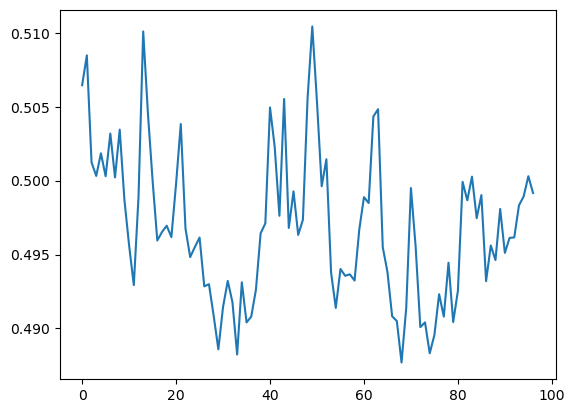

In [60]:
plt.plot(y_test_normal[1000])

In [8]:
class Decoder(Model):
    def __init__(self, layer_num, input_dim=2, output_dim=97,dropout_ratio = 0.1):
        super(Decoder, self).__init__()
        self.layer_num = layer_num
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.hidden_layers = []
        for i in range(layer_num):
            nodes = 2 ** (i + 1)
            self.hidden_layers.append(Dense(nodes, activation='linear'))
            self.hidden_layers.append(BatchNormalization())
            self.hidden_layers.append(LeakyReLU(alpha=0.01))
            self.hidden_layers.append(Dropout(rate = dropout_ratio))

        self.dense_output = Dense(output_dim, activation='sigmoid')

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.dense_output(x)
        return x
    
class Encoder(Model):
    def __init__(self, layer_num, input_dim=97, output_dim=2,dropout_ratio = 0.1):
        super(Encoder, self).__init__()
        self.layer_num = layer_num
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.hidden_layers = []
        for i in range(layer_num):
            nodes = 2 ** (layer_num - i)
            self.hidden_layers.append(Dense(nodes, activation='linear'))
            self.hidden_layers.append(BatchNormalization())
            self.hidden_layers.append(LeakyReLU(alpha=0.01))
            self.hidden_layers.append(Dropout(rate = dropout_ratio))

        self.dense_output = Dense(output_dim, activation='sigmoid')

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.dense_output(x)
        return x

In [9]:
class SAMModel(tf.keras.models.Model):
    def __init__(self, base_model, *args, rho=0.05, **kwargs):
        super().__init__( *args, **kwargs)
        self.rho = tf.constant(rho, dtype=tf.float32)
        self.base_model = base_model  

    def call(self, inputs):
        return self.base_model(inputs)  

    def train_step(self,data):
        x, y = data

        # 1st step
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        norm = tf.linalg.global_norm(gradients)
        scale = self.rho / (norm + 1e-12)
        e_w_list = []
        for v, grad in zip(trainable_vars, gradients):
            e_w = grad * scale
            v.assign_add(e_w)
            e_w_list.append(e_w)

        # 2nd step
        with tf.GradientTape() as tape:
            y_pred_adv = self(x, training=True)
            loss_adv = self.compiled_loss(y, y_pred_adv, regularization_losses=self.losses)
        gradients_adv = tape.gradient(loss_adv, trainable_vars)
        for v, e_w in zip(trainable_vars, e_w_list):
            v.assign_sub(e_w)

        # optimize
        self.optimizer.apply_gradients(zip(gradients_adv, trainable_vars))

        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

def cosine_similarity_loss(y_true, y_pred):
    # コサイン類似度を計算
    y_true = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred = tf.nn.l2_normalize(y_pred, axis=-1)
    cos_sim = tf.reduce_sum(y_true * y_pred, axis=-1)
    # 類似度を損失として使用するために、1から引く
    loss = 1 - cos_sim
    return loss
inputs = tf.keras.layers.Input(shape=(2,))
base_model = Decoder(layer_num=6, input_dim=2, output_dim=97,dropout_ratio = 0)
model = SAMModel(base_model = base_model, rho=0.05)
# model = base_model
# model.compile(loss=cosine_similarity_loss, optimizer="Adam")
model.compile(loss='mse', optimizer="Adam")
model.build(input_shape=(None, 2))  # None はバッチサイズを表し、2は入力特徴の次元数です。
model.summary()

Model: "sam_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder (Decoder)           multiple                  9667      
                                                                 
Total params: 9667 (37.76 KB)
Trainable params: 9415 (36.78 KB)
Non-trainable params: 252 (1008.00 Byte)
_________________________________________________________________


2024-06-12 14:19:11.497319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 14:19:11.521100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 14:19:11.523760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
def min_max_scaler(arr,min_val,max_val):
    arr = (arr-min_val)/(max_val-min_val)   
    arr = np.where(arr < 0, 0, arr)
    arr = np.where(arr > 1, 1, arr)
    return arr


std_weight = 50
for idx in range(y_train.shape[1]):
    mean_val = y_train[:,idx].mean()
    std_val = y_train[:,idx].std()
    max_val = mean_val + std_weight*std_val
    min_val = mean_val - std_weight*std_val
    y_train[:,idx] = min_max_scaler(y_train[:,idx], min_val, max_val)
    y_test_abnormal[:,idx] = min_max_scaler(y_test_abnormal[:,idx], min_val, max_val)
    y_test_normal[:,idx] = min_max_scaler(y_test_normal[:,idx], min_val, max_val)

In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
model.fit(
    x_train, 
    y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2,
    shuffle=True, 
    callbacks=[callback]
)

Epoch 1/30


2024-06-12 14:19:14.237200: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb244fb3300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-12 14:19:14.237216: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-06-12 14:19:14.240076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-12 14:19:14.251406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-06-12 14:19:14.302473: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


185/185 [==============================] - 4s 6ms/step - loss: 0.0019 - val_loss: 3.2895e-04
Epoch 2/30
185/185 [==============================] - 1s 5ms/step - loss: 2.1473e-04 - val_loss: 1.3183e-04
Epoch 3/30
185/185 [==============================] - 1s 5ms/step - loss: 1.5383e-04 - val_loss: 1.1922e-04
Epoch 4/30
185/185 [==============================] - 1s 5ms/step - loss: 1.3259e-04 - val_loss: 1.2025e-04
Epoch 5/30
185/185 [==============================] - 1s 5ms/step - loss: 1.2198e-04 - val_loss: 1.0637e-04
Epoch 6/30
185/185 [==============================] - 1s 5ms/step - loss: 1.1567e-04 - val_loss: 1.0527e-04
Epoch 7/30
185/185 [==============================] - 1s 5ms/step - loss: 1.0802e-04 - val_loss: 1.0881e-04
Epoch 8/30
185/185 [==============================] - 1s 5ms/step - loss: 1.0263e-04 - val_loss: 1.0681e-04
Epoch 9/30
185/185 [==============================] - 1s 5ms/step - loss: 1.0309e-04 - val_loss: 1.0696e-04
Epoch 10/30
185/185 [======================

1/1 [==============================] - 0s 16ms/step


IndexError: index 10 is out of bounds for axis 0 with size 10

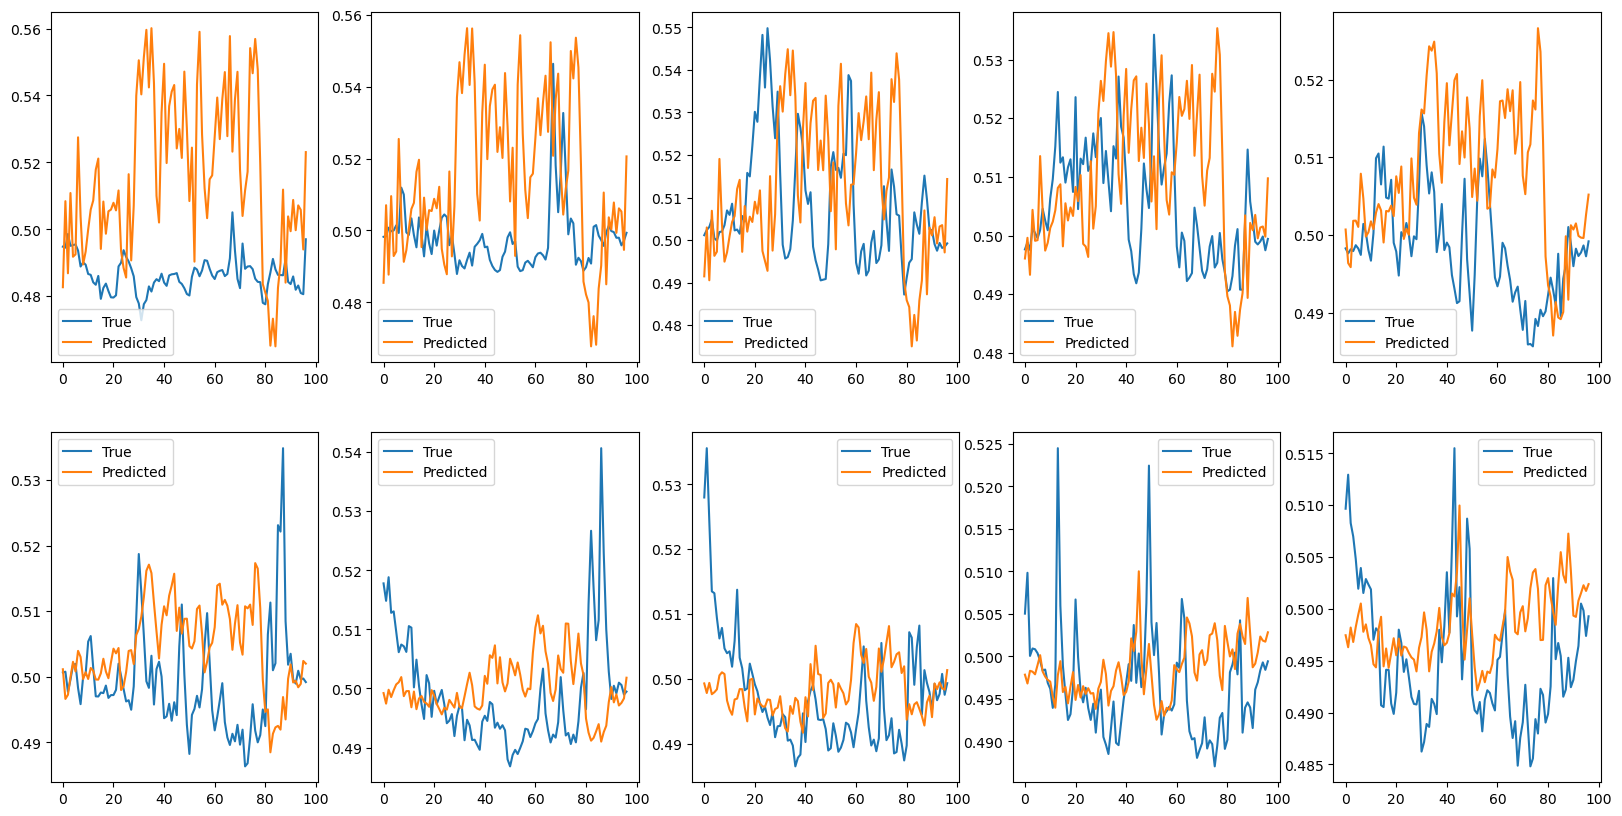

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error


# Configuration
start_index = 160  # Starting point for the y
num_graphs = 10  # Number of subplots to generate
index_step = 20 # Index increment between y

# Set up the figure and the subplots grid
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust rows/columns as needed
axs = axs.flatten()  # Flattening to easily index

# Plot each graph in a separate subplot
for i in range(num_graphs):
    # current_index = start_index + i * index_step
    current_index = int(y_test_normal.shape[0] * i /num_graphs)
    x = np.expand_dims(x_test_normal[current_index], axis=0)  # Adjust input shape if necessary
    y_predicted = model.predict(x)
    y_predicted = np.squeeze(y_predicted)
    
    
    # Plot original vs predicted in the current subplot
    axs[i].plot(y_test_normal[current_index].T, label='True')
    axs[i].plot(y_predicted.T, label='Predicted')
    axs[i].legend()

# Adjust the layout to prevent overlap and show the plot
plt.tight_layout()
plt.show()


In [13]:
print(y_train.shape, y_test_abnormal.shape, y_test_normal.shape)

(7369, 97) (2457, 97) (2456, 97)


1/1 [==============================] - 0s 14ms/step


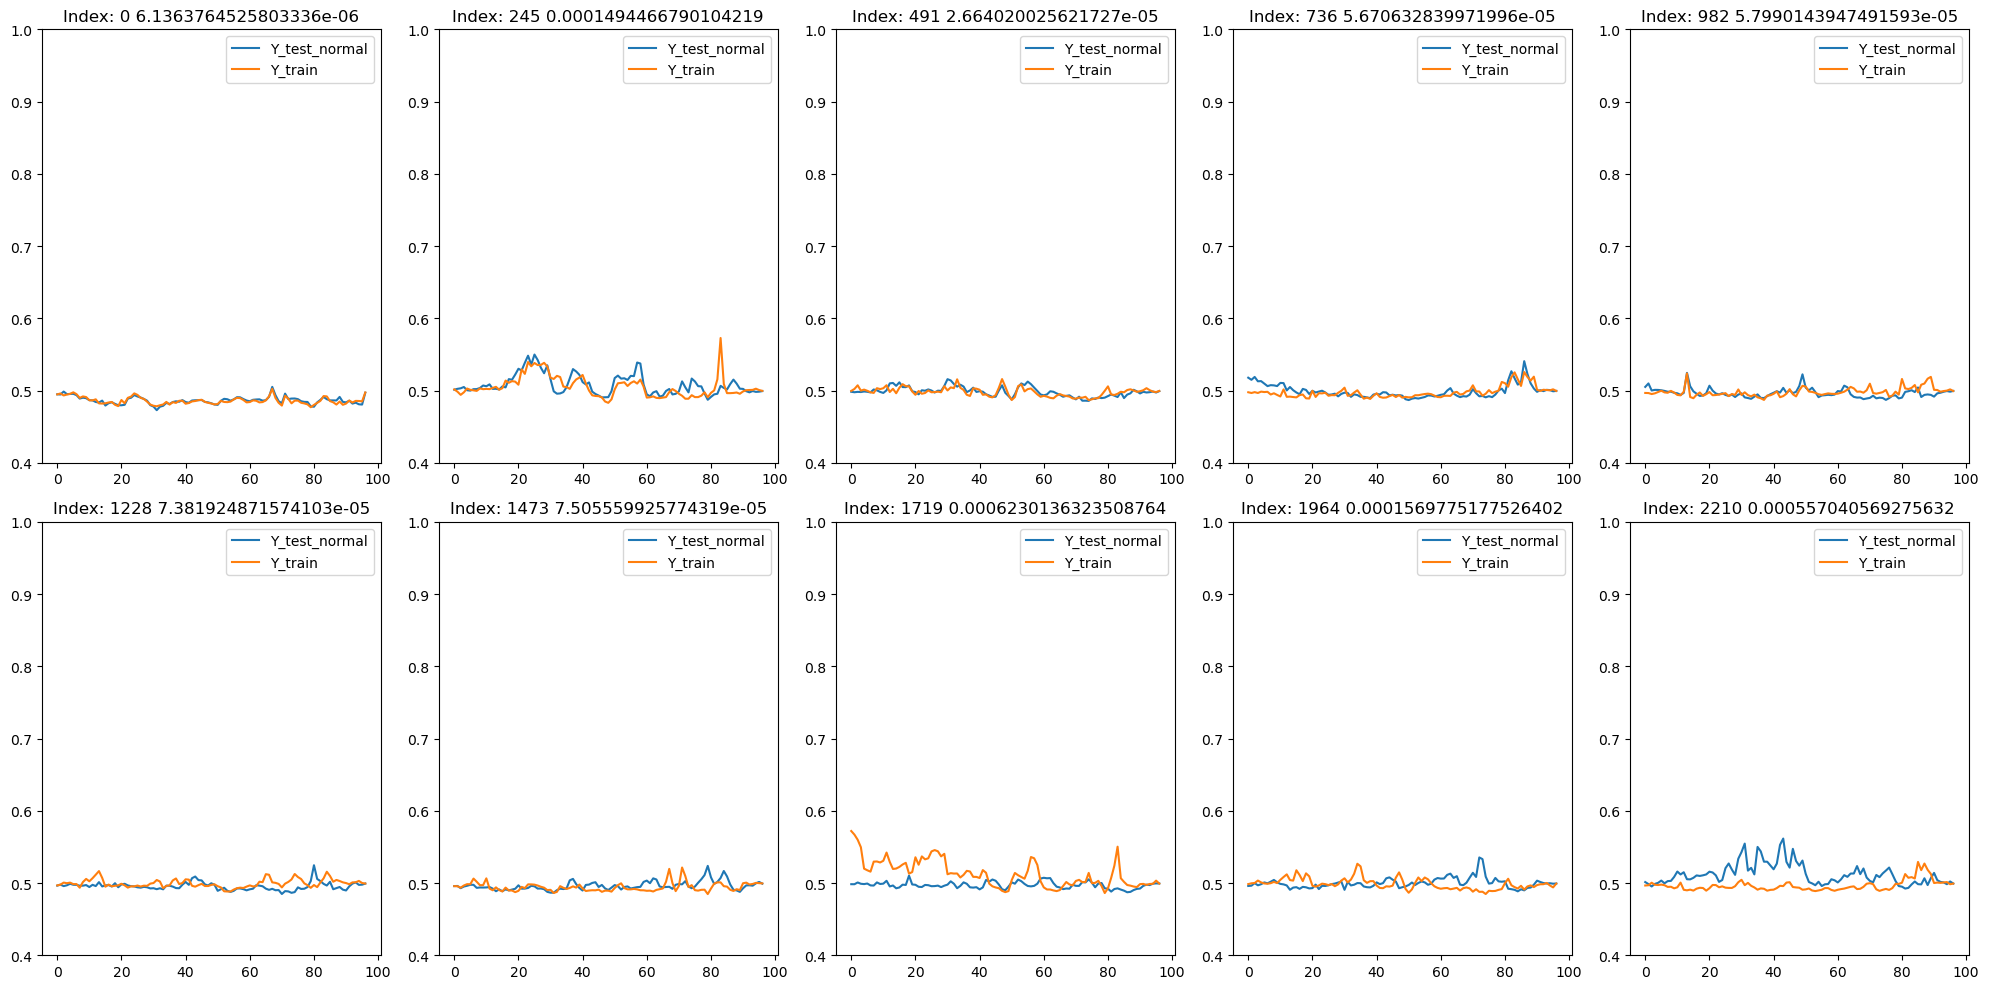

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error


# Configuration
start_index = 160  # Starting point for the graphs
num_graphs = 10  # Number of subplots to generate
index_step = 20 # Index increment between graphs

# Set up the figure and the subplots grid
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust rows/columns as needed
axs = axs.flatten()  # Flattening to easily index

# Plot each graph in a separate subplot
for i in range(num_graphs):
    # current_index = start_index + i * index_step
    current_index = int(y_test_normal.shape[0] * i /num_graphs)
    x = np.expand_dims(x_test_normal[current_index], axis=0)  # Adjust input shape if necessary
    y_predicted = model.predict(x)
    y_predicted = np.squeeze(y_predicted)
    
    # 平均二乗誤差を計算
    mse = mean_squared_error(y_train[current_index], y_test_normal[current_index])
    
    # Plot original vs predicted in the current subplot
    axs[i].plot(y_test_normal[current_index].T, label='Y_test_normal')
    axs[i].plot(y_train[current_index], label='Y_train')
    axs[i].set_ylim(0.4,1)
    axs[i].set_title(f'Index: {current_index} {mse}')
    axs[i].legend()

# Adjust the layout to prevent overlap and show the plot
plt.tight_layout()
plt.show()


<Axes: ylabel='Count'>

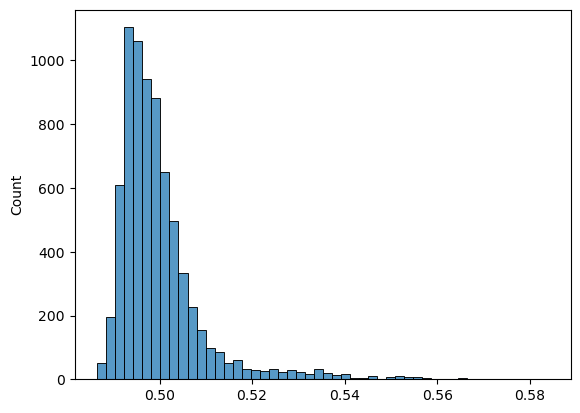

In [15]:
sns.histplot(y_train[:,10], bins=50)

y_predicted_train = model.predict(x_train)
y_predicted_normal = model.predict(x_test_normal)
y_predicted_abnormal = model.predict(x_test_abnormal)

In [16]:
y_predicted_train = model.predict(x_train)
y_predicted_abnormal = model.predict(x_test_abnormal)
y_predicted_normal = model.predict(x_test_normal)


77/77 [==============================] - 0s 723us/step


In [17]:
print(y_predicted_normal.shape, y_test_normal.shape)

(2456, 97) (2456, 97)


In [18]:
cosine_similarity_train = []
for i in range(y_train.shape[0]):
    cos_sim = cosine_similarity(y_predicted_train[i].reshape(1, -1), y_train[i].reshape(1, -1))[0, 0]
    cosine_similarity_train.append(cos_sim)

cosine_similarity_normal = []
for i in range(y_predicted_normal.shape[0]):
    cos_sim = cosine_similarity(y_predicted_train[i].reshape(1, -1), y_train[i].reshape(1, -1))[0, 0]
    cosine_similarity_normal.append(cos_sim)

cosine_similarity_abnormal = []
for i in range(y_predicted_abnormal.shape[0]):
    cos_sim = cosine_similarity(y_predicted_abnormal[i].reshape(1, -1), y_test_abnormal[i].reshape(1, -1))[0, 0]
    cosine_similarity_abnormal.append(cos_sim)

In [21]:
max(x_test_abnormal[:,1])
new_ls = set(x_test_abnormal[:,1])
new_ls.remove(max(new_ls))
result = max(new_ls) #２番目に大きい値を取得

#x_test_normalとx_test_abnormalを原点を基準とした座標に変換
x_test_normal = (x_test_normal - [0.98, 1.26])*-1
x_test_abnormal = (x_test_abnormal - [0.98, 1.26])*-1

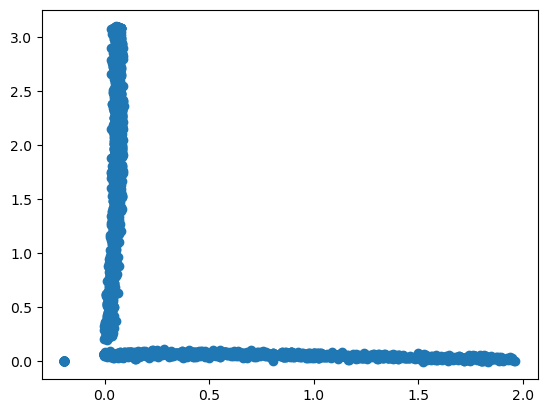

In [25]:
plt.plot(x_test_abnormal[:,0], x_test_abnormal[:,1], 'o', label='abnormal')

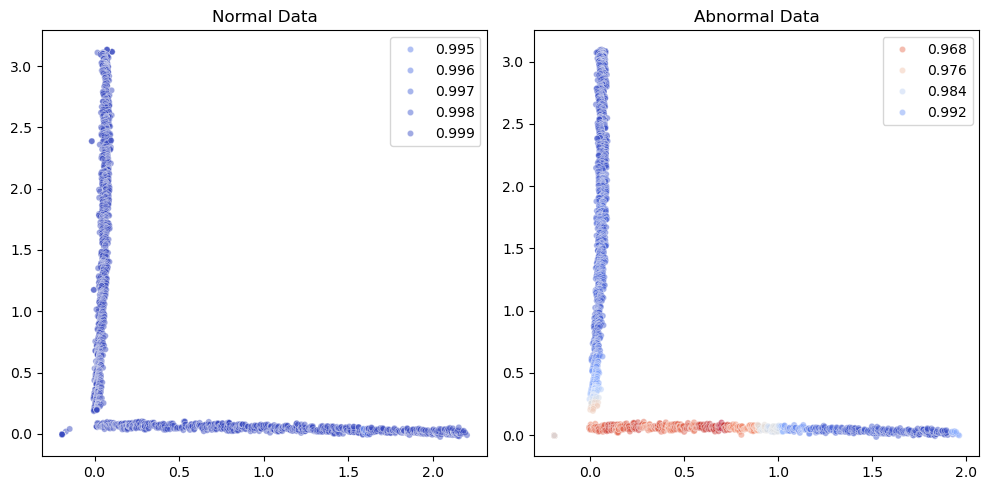

In [26]:
import seaborn as sns
# MSEの全体的な最小値と最大値を計算
cosine_similarity_min = min(min(cosine_similarity_normal), min(cosine_similarity_abnormal))
cosine_similarity_max = max(max(cosine_similarity_normal), max(cosine_similarity_abnormal))

# 正常データのプロット
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=x_test_normal[:, 0],
    y=x_test_normal[:, 1],
    hue=cosine_similarity_normal,
    s=20,
    alpha=0.5,
    palette='coolwarm_r',
    hue_norm=(cosine_similarity_min, cosine_similarity_max)
)
plt.title('Normal Data')

# 異常データのプロット
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=x_test_abnormal[:, 0],
    y=x_test_abnormal[:, 1],
    hue=cosine_similarity_abnormal,
    s=20,
    alpha=0.5,
    palette='coolwarm_r',
    hue_norm=(cosine_similarity_min, cosine_similarity_max)
)
plt.title('Abnormal Data')

plt.tight_layout()
plt.show()

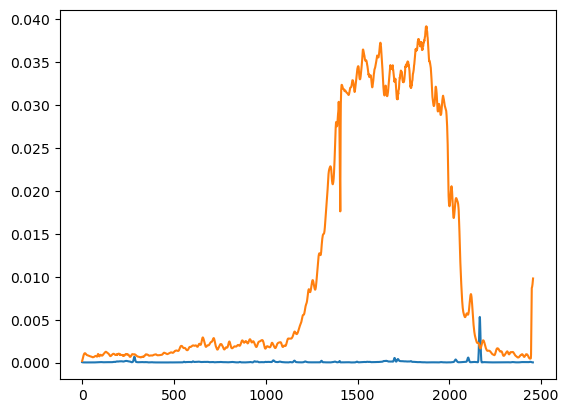

In [27]:
# plt.plot(np.array(cosine_similarity_abnormal))
plt.plot(1-np.array(cosine_similarity_normal))
plt.plot(1-np.array(cosine_similarity_abnormal))

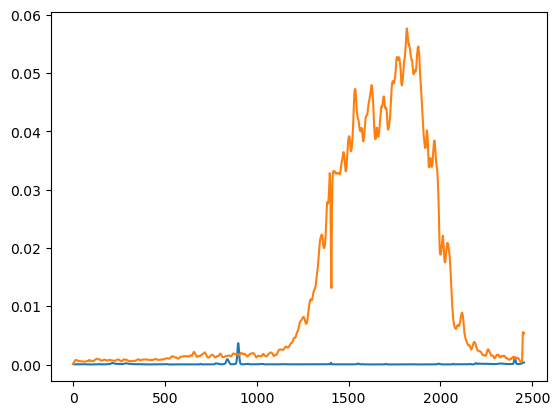

In [28]:
mse_normal = np.mean(np.square(y_predicted_normal - y_test_normal), axis=1)
mse_abnormal = np.mean(np.square(y_predicted_abnormal - y_test_abnormal), axis=1)
plt.plot(mse_normal, label='normal')
plt.plot(mse_abnormal, label='abnormal')

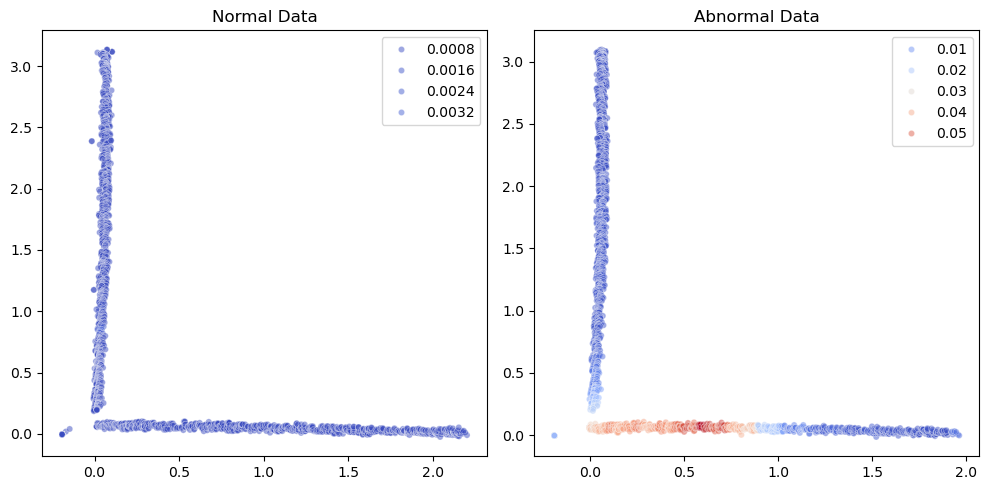

In [29]:
import seaborn as sns
# MSEの全体的な最小値と最大値を計算
mse_min = min(min(mse_normal), min(mse_abnormal))
mse_max = max(max(mse_normal), max(mse_abnormal))

# 正常データのプロット
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=x_test_normal[:, 0],
    y=x_test_normal[:, 1],
    hue=mse_normal,
    s=20,
    alpha=0.5,
    palette='coolwarm',
    hue_norm=(mse_min, mse_max)
)
plt.title('Normal Data')

# 異常データのプロット
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=x_test_abnormal[:, 0],
    y=x_test_abnormal[:, 1],
    hue=mse_abnormal,
    s=20,
    alpha=0.5,
    palette='coolwarm',
    hue_norm=(mse_min, mse_max)
)
plt.title('Abnormal Data')

plt.tight_layout()
plt.show()

<Axes: xlabel='mse', ylabel='Count'>

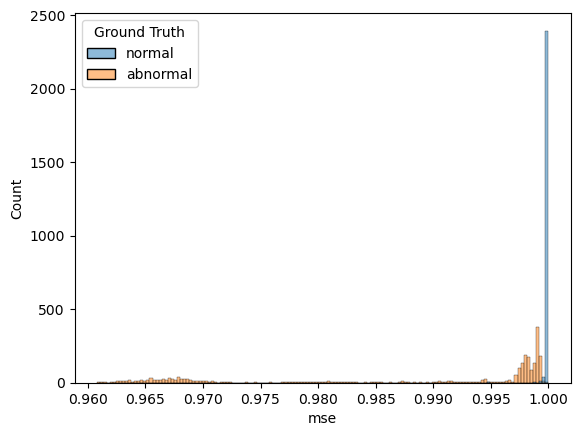

In [30]:
plt_df_normal = pd.DataFrame({'mse':cosine_similarity_normal})
plt_df_normal['Ground Truth'] = 'normal'
plt_df_abnormal = pd.DataFrame({'mse':cosine_similarity_abnormal})
plt_df_abnormal['Ground Truth'] = 'abnormal'

plt_df = pd.concat([plt_df_normal, plt_df_abnormal], ignore_index=True)
sns.histplot(
    data=plt_df,
    x='mse',
    hue='Ground Truth'
)

In [31]:
plt_df['Label'] = plt_df['Ground Truth']=='abnormal'
plt_df

,mse,Ground Truth,Label
0,0.999949,normal,False
1,0.999958,normal,False
2,0.999965,normal,False
3,0.999969,normal,False
4,0.999971,normal,False
...,...,...,...
4908,0.991038,abnormal,True
4909,0.990872,abnormal,True
4910,0.990671,abnormal,True
4911,0.990436,abnormal,True


In [32]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# Min-Maxスケーリング
scaler = MinMaxScaler()
y_scores_scaled = scaler.fit_transform(np.array(plt_df['mse']).reshape(-1, 1)).flatten()
y_scores_scaled = 1-y_scores_scaled

# AUC計算
auc = roc_auc_score(plt_df['Label'], y_scores_scaled)
# 結果の出力
print(f"AUC: {auc:.4f}")


AUC: 0.9971


In [33]:
plt_df


,mse,Ground Truth,Label
0,0.999949,normal,False
1,0.999958,normal,False
2,0.999965,normal,False
3,0.999969,normal,False
4,0.999971,normal,False
...,...,...,...
4908,0.991038,abnormal,True
4909,0.990872,abnormal,True
4910,0.990671,abnormal,True
4911,0.990436,abnormal,True


AEとの比較

In [34]:
#12次元の入力を2次元に圧縮　autoencoder
class AutoEncoder(Model):
    def __init__(self, layer_num, input_dim=97, output_dim=2,dropout_ratio = 0.1):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(layer_num, input_dim, output_dim,dropout_ratio)
        self.decoder = Decoder(layer_num, output_dim, input_dim,dropout_ratio)

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x

ae = AutoEncoder(4)
ae.compile(optimizer='adam', loss='mean_squared_error')
ae.fit(y_train, y_train, epochs=30, batch_size=32)


Epoch 1/30
231/231 [==============================] - 4s 4ms/step - loss: 0.0017
Epoch 2/30
231/231 [==============================] - 1s 4ms/step - loss: 3.2120e-04
Epoch 3/30
231/231 [==============================] - 1s 4ms/step - loss: 1.8319e-04
Epoch 4/30
231/231 [==============================] - 1s 4ms/step - loss: 1.3214e-04
Epoch 5/30
231/231 [==============================] - 1s 4ms/step - loss: 1.1514e-04
Epoch 6/30
231/231 [==============================] - 1s 4ms/step - loss: 1.0636e-04
Epoch 7/30
231/231 [==============================] - 1s 4ms/step - loss: 1.0317e-04
Epoch 8/30
231/231 [==============================] - 1s 4ms/step - loss: 1.0112e-04
Epoch 9/30
231/231 [==============================] - 1s 4ms/step - loss: 1.0002e-04
Epoch 10/30
231/231 [==============================] - 1s 4ms/step - loss: 9.9601e-05
Epoch 11/30
231/231 [==============================] - 1s 4ms/step - loss: 9.8777e-05
Epoch 12/30
231/231 [==============================] - 1s 4ms/step 

77/77 [==============================] - 0s 883us/step
AUC: 0.9921


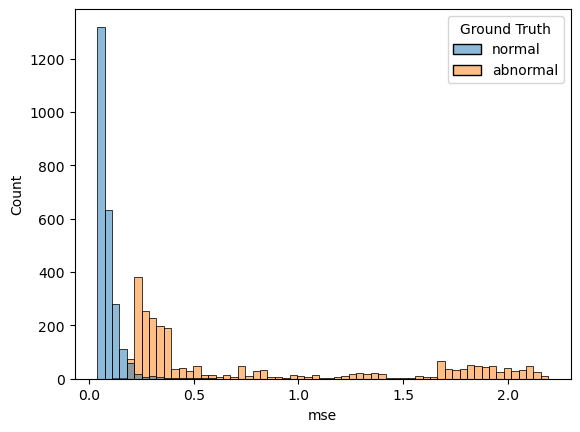

In [35]:
mse_abnormal = np.sqrt(np.sum((ae.predict(y_test_abnormal) - y_test_abnormal)**2, axis=1))
mse_normal = np.sqrt(np.sum((ae.predict(y_test_normal) - y_test_normal)**2, axis=1))

plt_df_normal = pd.DataFrame({'mse':mse_normal})
plt_df_normal['Ground Truth'] = 'normal'
plt_df_abnormal = pd.DataFrame({'mse':mse_abnormal})
plt_df_abnormal['Ground Truth'] = 'abnormal'

plt_df = pd.concat([plt_df_normal, plt_df_abnormal], ignore_index=True)
sns.histplot(
    data=plt_df,
    x='mse',
    hue='Ground Truth'
)
plt_df['Label'] = plt_df['Ground Truth']=='abnormal'


# Min-Maxスケーリング
scaler = MinMaxScaler()
y_scores_scaled = scaler.fit_transform(np.array(plt_df['mse']).reshape(-1, 1)).flatten()

# AUC計算
auc = roc_auc_score(plt_df['Label'], y_scores_scaled)
# 結果の出力
print(f"AUC: {auc:.4f}")

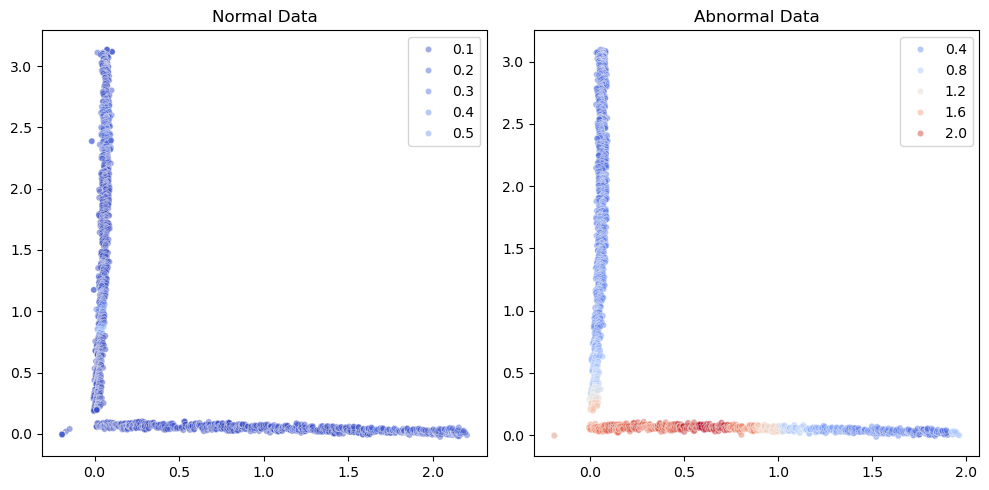

In [36]:
import seaborn as sns
# MSEの全体的な最小値と最大値を計算
mse_min = min(min(mse_normal), min(mse_abnormal))
mse_max = max(max(mse_normal), max(mse_abnormal))

# 正常データのプロット
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=x_test_normal[:, 0],
    y=x_test_normal[:, 1],
    hue=mse_normal,
    s=20,
    alpha=0.5,
    palette='coolwarm',
    hue_norm=(mse_min, mse_max)
)
plt.title('Normal Data')

# 異常データのプロット
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=x_test_abnormal[:, 0],
    y=x_test_abnormal[:, 1],
    hue=mse_abnormal,
    s=20,
    alpha=0.5,
    palette='coolwarm',
    hue_norm=(mse_min, mse_max)
)
plt.title('Abnormal Data')

plt.tight_layout()
plt.show()

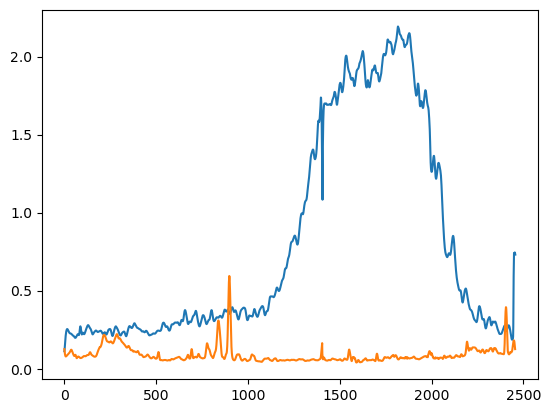

In [37]:
# plt.plot(np.array(cosine_similarity_abnormal))
plt.plot(mse_abnormal)
plt.plot(mse_normal)

In [142]:
y_test_abnormal = combined_df_abnormal[y_columns_to_use].values
y_train = combined_df[y_columns_to_use].values

In [143]:
def min_max_scaler(arr,min_val,max_val):
    arr = (arr-min_val)/(max_val-min_val)   
    arr = np.where(arr < 0, 0, arr)
    # arr = np.where(arr > 1, 1, arr)
    return arr


std_weight = 10
for idx in range(y_train.shape[1]):
    mean_val = y_train[:,idx].mean()
    std_val = y_train[:,idx].std()
    max_val = mean_val + std_weight*std_val
    min_val = mean_val - std_weight*std_val
    y_train[:,idx] = min_max_scaler(y_train[:,idx], min_val, max_val)
    y_test_abnormal[:,idx] = min_max_scaler(y_test_abnormal[:,idx], min_val, max_val)
    y_test_normal[:,idx] = min_max_scaler(y_test_normal[:,idx], min_val, max_val)

In [144]:
y_predicted_abnormal = model.predict(x_test_abnormal)   
diff_abnormal = y_test_abnormal - y_predicted_abnormal

77/77 [==============================] - 0s 775us/step


In [145]:
x_test_abnormal[0]

array([ 0.91835545, -1.83338221])

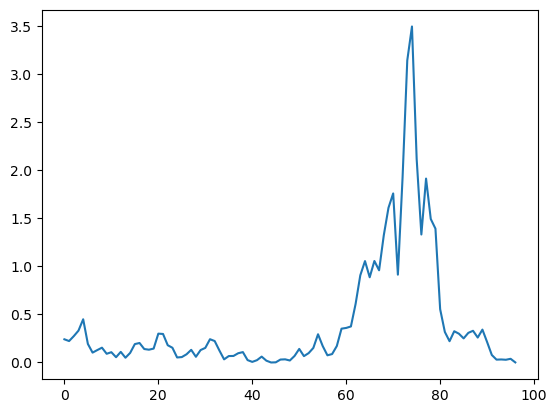

In [147]:
plt.plot(diff_abnormal[2000])

In [148]:
import numpy as np
from scipy.optimize import minimize

# 仮定するεの値を設定
epsilon = 1e-5

# 目的関数の定義
def objective(params):
    x, y, *m = params
    sum_sq_error = 0
    for j in range(diff_abnormal.shape[0]):
        alpha_j = 1 / ((x - x_test_abnormal[j, 0])**2 + (y - x_test_abnormal[j, 1])**2 + epsilon)
        for i in range(diff_abnormal.shape[1]):
            sum_sq_error += (diff_abnormal[j, i] - alpha_j * m[i]) ** 2
    return sum_sq_error

# 初期パラメータの設定
initial_guess = [0.0, 0.0] + [0.5] * diff_abnormal.shape[1]

# パラメータの範囲の設定
bounds = [(-1.0, 3.0), (-1.0, 3.0)] + [(0.01, 1.0)] * diff_abnormal.shape[1]

# 最適化の実行
result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')

# 結果の表示
if result.success:
    x_opt, y_opt, *m_opt = result.x
    print("Optimized x:", x_opt)
    print("Optimized y:", y_opt)
    print("Optimized m:", m_opt)
else:
    print("Optimization failed:", result.message)


Optimized x: 0.5485568532526691
Optimized y: 1.6591912402320157
Optimized m: [0.06496497976928085, 0.12454457330460947, 0.10927060650475798, 0.09879552376794992, 0.05978167306054569, 0.04207323828688092, 0.03049831634858055, 0.02519864075817191, 0.02559983561946386, 0.01944653406460325, 0.015541219313206204, 0.015215415569087105, 0.026030887808482943, 0.027293869810782936, 0.02846725188070036, 0.038077402887090245, 0.03366988622530503, 0.03403902335543808, 0.04795776624345114, 0.04728634873881151, 0.06640434902410439, 0.045656228953493715, 0.030548278241478318, 0.021175230491929545, 0.01079470750844791, 0.013893981685819411, 0.01610105182263183, 0.024294432529274042, 0.02662671328621201, 0.035957460524109384, 0.04802646846132899, 0.08206014897166626, 0.065750761069332, 0.026257381255837972, 0.01, 0.018712374142050035, 0.02317865814538209, 0.02352828759081889, 0.015800735898451473, 0.010980207813071732, 0.015155715000713358, 0.011168443010085922, 0.019575576634188067, 0.0151773330677832

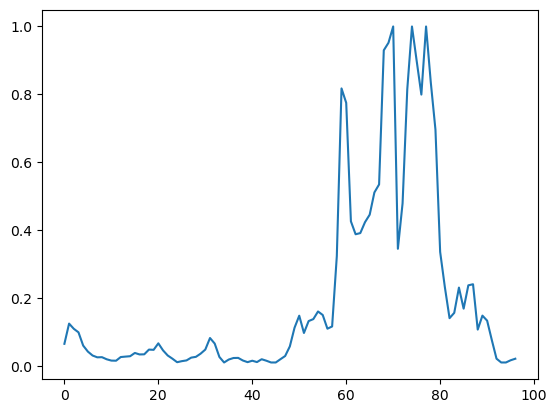

In [150]:
plt.plot(m_opt)